In [12]:
import numpy as np
import matplotlib.pyplot as plt
import math

import pennylane as qml
from pennylane import numpy as pnp

import warnings
warnings.filterwarnings('ignore')

In [13]:
n = 10
sky_image = np.zeros((n, n), dtype='complex64')
mask = np.zeros((n, n), dtype='bool')
number_of_stars = np.random.randint(1, 7)
radius = 1 

for i in range(0, number_of_stars):
    index_i = np.random.randint(0, sky_image.shape[0]-radius)
    index_j = np.random.randint(0, sky_image.shape[1]-radius)
    for j in range(0, radius):
        for k in range(0, radius):
            sky_image[index_i+j][index_j+k] = complex(np.random.rand()*100, np.random.rand()*100)
            mask[index_i+j][index_j+k] = True
            
sky_image.real += np.random.randn(n,n)/100
sky_image.imag += np.random.randn(n,n)/100

print(sky_image)

[[-7.58207287e-04+5.6645633e-03j -1.19958976e-02-6.5716300e-03j
   3.47523764e-03-4.8578149e-03j  4.53172205e-03+1.4278044e-03j
   9.64659546e-03+5.0739325e-03j -4.70858393e-03+1.6093181e-02j
  -1.37079158e-03+4.8301350e-03j -3.70597164e-03+8.8212378e-03j
   2.76221498e-03-9.1932397e-03j -1.40298782e-02+7.0365667e-03j]
 [-1.80924125e-02+1.4916738e-03j -1.01887165e-02+2.3961557e-02j
  -7.70470640e-03+4.8466697e-03j -1.27930511e-02+9.2822490e-03j
   1.12426346e-02+5.7024164e-03j -6.18811324e-03+1.5192556e-02j
   3.90822161e-03+6.2749744e-03j  7.31678726e-03-4.8728283e-03j
  -4.53352183e-03+1.0883139e-02j -3.12034227e-02+1.3821025e-02j]
 [-1.36630926e-02-2.4597488e-02j  7.08918436e-04+5.1775603e-03j
   2.77868309e-03-7.6125092e-03j -2.57480680e-03+2.5667541e-02j
   1.66527554e-02-3.1848482e-03j -1.08123319e-02-1.6151502e-03j
   1.04234433e-02+7.7469554e-03j -1.57058996e-03+4.3537728e-03j
   1.55638494e-02+4.4638873e-03j -5.76123886e-04-2.2621690e-03j]
 [-2.37906864e-03+8.3317393e-03j  1.4

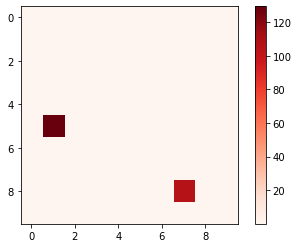

In [14]:
modulus = np.absolute(sky_image)
plt.imshow(modulus, cmap='Reds')
plt.colorbar();

In [15]:
visibilities = np.fft.fft2(sky_image).astype('complex64')
print(visibilities)

[[ 184.33284  +146.00655j     44.3704    +76.169426j
    76.17795  -166.13702j    157.17778  -121.28056j
   -58.801064  -24.726713j  -184.29224  -145.99721j
   -44.554707  -76.24816j    -76.150406 +166.03604j
  -157.31721  +121.25498j     58.709003  +24.4592j   ]
 [-127.69305   +16.254196j  -216.14264   -72.399124j
   -27.05337    +1.7612541j  -16.308914 +218.80005j
   -77.770134 +128.6356j     127.76183   -16.192175j
   216.07507   +72.572395j    27.035875   -1.5868112j
    16.245998 -218.78757j     77.552025 -128.52946j  ]
 [  -9.003275  +87.87706j    159.29358   -89.48161j
   198.46716    -5.4788547j  -33.089886  -54.663857j
   -63.385654 -226.29518j      8.829199  -88.013664j
  -159.36003   +89.5446j    -198.65642    +5.709208j
    33.040806  +54.661312j    63.3938   +226.36891j  ]
 [-132.06448  -185.5377j     -22.821981  -14.504456j
  -141.79167  +167.56543j   -138.45972   +58.54839j
   112.69231   +61.94253j    132.20576  +185.68443j
    22.862919  +14.526889j   141.8413   -167.7

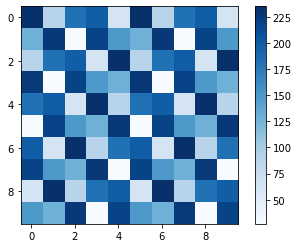

In [16]:
modulus = np.absolute(visibilities)
plt.imshow(modulus, cmap='Blues')
plt.colorbar();

In [17]:
sanity = np.fft.ifft2(visibilities).astype('complex64')

test1_real = ((sky_image.real - sanity.real)**2).mean()
test1_imag = ((sky_image.imag - sanity.imag)**2).mean()
 
print('Reals MSE: '+ str(test1_real))
print('Imaginaries MSE: '+ str(test1_imag))

Reals MSE: 8.994007e-14
Imaginaries MSE: 7.156881e-14


In [18]:
print( 'Encodes log2(n) qubits: ' + str(math.log2(n*n)) )

Encodes log2(n) qubits: 6.643856189774724


Wires: range(0, 7)
100
128


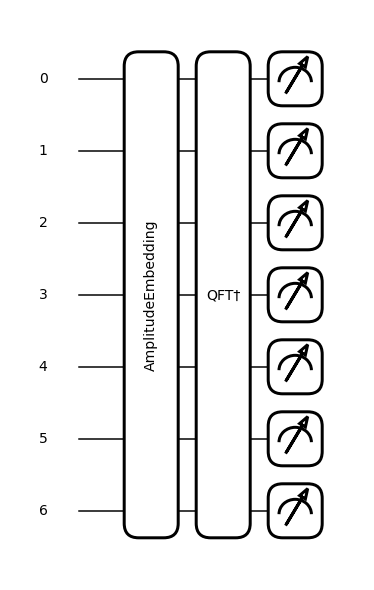

In [19]:
n_n = visibilities.shape[0]*visibilities.shape[1]
inp = visibilities.flatten()

norm = qml.math.sum(qml.math.abs(inp) ** 2)
#normalized_data = data / qml.math.sqrt(norm)

wires = range(math.ceil(math.log2(n_n)))
print( 'Wires: ' + str(wires) )
amp_dev = qml.device('default.qubit', wires)


@qml.qnode(amp_dev)
def amp_encoding(data):
    qml.AmplitudeEmbedding(data, wires, normalize=True, pad_with=0.)
    qml.adjoint(qml.QFT)(wires=wires)
    return qml.state()

readout = amp_encoding(inp).astype('complex64')
qml.draw_mpl(amp_encoding)(inp)

print(len(inp))
print(len(readout))

readout.numpy()
readout = readout[:100]
readout = readout*qml.math.sqrt(norm)
readout = np.array(readout).reshape(sky_image.shape[0] , sky_image.shape[1])

In [9]:
fidelity = readout
#fidelity = np.fft.ifft2(readout).astype('complex64')

test2_real = ((sky_image.real - fidelity.real)**2).mean()
test2_imag = ((sky_image.imag - fidelity.imag)**2).mean()

print('Reals MSE: '+ str(test2_real))
print('Imaginaries MSE: '+ str(test2_imag))

Reals MSE: 14945.392
Imaginaries MSE: 28437.31


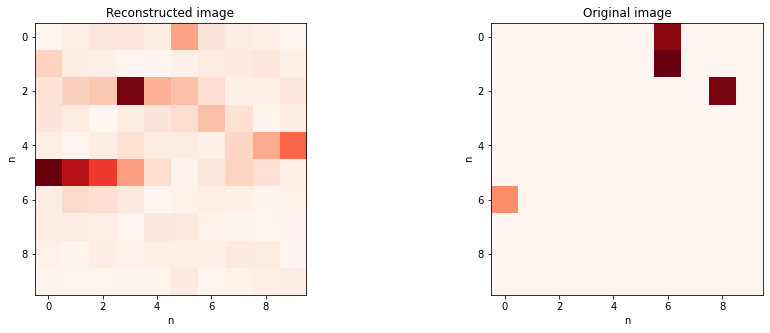

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
modulus1 = np.absolute(fidelity)
modulus2 = np.absolute(sky_image)

axs[0].imshow(modulus1, cmap='Reds')
axs[1].imshow(modulus2, cmap='Reds')

axs[0].set_title("Reconstructed image")
axs[1].set_title("Original image")

for ax in axs.flat:
    ax.set(xlabel='n', ylabel='n')